In [2]:
# Build-in imports
import os
import sys
import math
from pathlib import Path

# 3rd party imports
import json
import pandas as pd
import pm4py
from pm4py.objects.log.obj import EventLog
from pm4py.objects.log.util import sampling
from pm4py.objects.process_tree import obj as pt
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_alg
from pm4py.algo.evaluation.generalization import algorithm as generalization_alg

# DPIM imports (from the DPIM repo)
sys.path.insert(0, os.path.abspath("./DPIM")) # Fixes an issue with importing

from DPIM.main import DPIM
from DPIM.utils import eventLog_parsing

In [3]:
def get_event_log_hyperparameters(
    results_filename: str = "./DPIM/evaluation_results/Evaluation_Results_DPIM.xlsx",
    event_log_dir: str = "./Evaluation Logs"
) -> dict:
    # The authors of the DPIM paper save their experiments' hyperparameters and results in this file 
    df_raw: pd.DataFrame = pd.read_excel(
        io=results_filename,
        header=[0, 1]  # two-row header
    )

    df: pd.DataFrame = df_raw.copy()

    df.columns = [
        f"{a}_{b}".strip("_")
        for a, b in df.columns
    ]

    df: pd.DataFrame = df.dropna(subset=["Event Logs_Event Log"])
    df: pd.DataFrame = df.reset_index(drop=True)

    event_log_hyperparameters: dict = {}

    for file in os.listdir(event_log_dir):
        if not file.endswith(".gz"):
            continue

        log_name: str = Path(file).name.removesuffix(".xes.gz")
        row = df.loc[df["Event Logs_Event Log"] == log_name]

        lower: int = int(row["Hyperparameters_Lower"].iloc[0])
        upper: int = int(row["Hyperparameters_Upper"].iloc[0])
        fitness_threshold: float = float(row["Hyperparameters_Fitness"].iloc[0])
        
        event_log_hyperparameters[log_name] = {
            "lower_bound": lower,
            "upper_bound": upper,
            "fitness_threshold": fitness_threshold
        }
    
    return event_log_hyperparameters

In [4]:
def compute_dfr_bounds(log: EventLog, margin: int = 15) -> tuple[int, int]:
    """
    Compute lower and upper bounds for DFR selection based on the actual
    directly-follows relation in the sampled log.
    
    This follows the approach from main.py where bounds are based on the
    number of activity pairs that actually occur in the log.
    
    Args:
        log: PM4Py EventLog (potentially sampled)
        margin: Number of edges to add/subtract from the count (default: 15)
    
    Returns:
        tuple: (lower_bound, upper_bound)
    """
    activities: dict = pm4py.get_event_attribute_values(log, 'concept:name')
    num_acts: int = len(activities)
    
    # Build the DFR with BINARY counting (as DPIM does in Algorithm 2, lines 5-7)
    # Count: "in how many traces does this edge appear?"
    edge_trace_counts = {}
    
    for trace in log:
        # Get unique edges in this trace (binary: 0 or 1 per trace)
        edges_in_trace = set()
        activities_in_trace = [event['concept:name'] for event in trace]
        
        # Add START edges
        if activities_in_trace:
            edges_in_trace.add(('START', activities_in_trace[0]))
        
        # Add internal edges
        for i in range(len(activities_in_trace) - 1):
            edges_in_trace.add((activities_in_trace[i], activities_in_trace[i+1]))
        
        # Add END edges
        if activities_in_trace:
            edges_in_trace.add((activities_in_trace[-1], 'END'))
        
        # Binary count: each edge appears at most once per trace
        for edge in edges_in_trace:
            edge_trace_counts[edge] = edge_trace_counts.get(edge, 0) + 1
    
    # Count edges that appear in at least one trace
    num_edges_with_frequency = len([cnt for cnt in edge_trace_counts.values() if cnt > 0])
    
    # Apply margin BEFORE rounding
    lower = num_edges_with_frequency - margin
    upper = num_edges_with_frequency + margin
    
    # Apply constraints
    lower = max(num_acts, lower)
    upper = min((num_acts ** 2) - 1, upper)
    
    # Round to nearest multiple of 5
    lower = 5 * round(lower / 5)
    upper = 5 * round(upper / 5)
    
    # Final sanity checks
    if lower < num_acts or lower >= upper:
        lower = num_acts
    if upper > (num_acts ** 2) - 1 or upper <= lower or upper < num_acts:
        upper = (num_acts ** 2) - 1
    
    return lower, upper

In [5]:
def dpim_tree_from_log(log: EventLog, dpim_cfg: dict):
    """
    Build a PM4Py ProcessTree using DPIM for a given PM4Py EventLog.
    
    Args:
        log: PM4Py EventLog object
        dpim_cfg: Configuration dict with keys:
          - no_dp: bool (if True => epsilon=100000, DP disabled)
          - epsilon: float (privacy parameter, default 1.0)
          - fitness_threshold: float (minimum fitness, default 0.95)
          - lower: int | None (lower bound for DFR selection)
          - upper: int | None (upper bound for DFR selection)
    
    Returns:
        pm4py ProcessTree object
        
    Raises:
        RuntimeError: If DPIM fails to construct a valid tree
        ValueError: If epsilon is invalid when DP is enabled
    """
    no_dp: bool = bool(dpim_cfg.get("no_dp", False))
    epsilon: float = float(dpim_cfg.get("epsilon", 1.0))
    fitness_threshold: float = float(dpim_cfg.get("fitness_threshold", 0.95))
    lower: int = dpim_cfg.get("lower", None)
    upper: int = dpim_cfg.get("upper", None)

    # Validate epsilon
    if not no_dp and epsilon <= 0:
        raise ValueError("epsilon must be positive when DP is enabled")

    # DPIM preprocessing (as used in main.py)
    permutations, traceList, num_acts = eventLog_parsing.xesFile().createPermutations_XES(event_log=log)

    # Bounds: mirror the logic from main.py defaults
    if lower is None:
        lower = num_acts
    if upper is None:
        upper = (num_acts ** 2) - 1

    miner = DPIM()
    miner.fit_trehsold = fitness_threshold
    miner.lower_bound = lower
    miner.upper_bound = upper

    if no_dp:
        miner.DP = False
         # IMPORTANT: do NOT set 100000 here otherwise recursion happens
        eps: float = float(dpim_cfg.get("epsilon", 1.0))
    else:
        miner.DP = True
        eps: float = epsilon

    tree: pt.ProcessTree = miner.create_tree(
        permutations=permutations,
        traceList=traceList,
        epsilon=eps,
        event_log=log
    )

    print("============== TREE VIA DPIM CREATED ==============")

    # Handle return values
    if tree is False:
        raise RuntimeError(
            "✗ DPIM rejection sampling did not find a tree meeting the fitness threshold. "
            "Try lowering fitness_threshold or increasing epsilon."
        )
    if tree is None:
        raise RuntimeError(
            "✗ DPIM tree construction failed (likely due to recursion limit). "
            "The model may be too complex for the selected edges."
        )

    return tree

In [8]:
def compute_metrics(log, mode: str = "pm4py_im", dpim_cfg: dict | None = None) -> list[float]:
    """
    This function takes a log for which a process tree is discovered and metrics are computed.
    The log is a required parameter and the rest are optional. If only a log is provided the standard IM
    via `pm4py` is used. Otherwise, the DPIM process tree can be build with either privacy or no privacy. 
    
    :param log: The Event Log for which metrics like fitness, precision, etc are computed.
    :param mode: 'pm4py_im' (baseline inductive miner via PM4Py), 'dpim' (DPIM process tree; configure via dpim_cfg)
    :param dpim_cfg: Contains values like epsilon, fitness threshold, lower- and upper bound.
    :return: Returns a list of metrics in this order - fitness, precision, simplicity, generalization.
    :rtype: list[float]
    """
    
    # 1) Discover a process tree depending on mode
    if mode == "pm4py_im":
        tree: pt.ProcessTree = pm4py.discover_process_tree_inductive(log)
        print("============== TREE VIA PM4Py CREATED ==============")
    elif mode == "dpim":
        if dpim_cfg is None:
            raise ValueError("When running DPIM a configuration needs to be passed!")
        tree: pt.ProcessTree = dpim_tree_from_log(log, dpim_cfg)
    else:
        raise ValueError(f"Unknown mode='{mode}'. Use 'pm4py_im' or 'dpim'.")
    
    # 2) Convert tree -> Petri net
    net, im, fm = pm4py.convert_to_petri_net(tree)
    print("============== PETRI NET CREATED ==============")
    
    # 3) Compute metrics
   
    # Fitness should be calculated when privacy is selected, otherwise no (see xlsx results in DPIM)
    fitness = 1
    
    # Differentially Private Inductive Miner with privacy (epsilon != 100_000, no_dp=False)
    if dpim_cfg is not None and dpim_cfg["no_dp"] is False:
        fitness = pm4py.fitness_token_based_replay(log, net, im, fm)['log_fitness']
        
    precision = pm4py.precision_token_based_replay(log, net, im, fm)  
    simplicity = simplicity_alg.apply(net)                    
    generalization = generalization_alg.apply(log, net, im, fm)
    
    print("============== METRICS COMPUTED ==============")
    
    return fitness, precision, simplicity, generalization

In [ ]:
"""
Iterate over all Event Logs used for evaluation in the DPIM paper and compute metrics for all variations:

IM using pm4py, DPIM with no privacy, DPIM with epsilon=3, DPIM with epsilon=1, DPIM with epsilon=0.1
"""

hyperparameters: dict = get_event_log_hyperparameters()
evaluation_results: list[dict] = []

directory: str = "./Evaluation Logs"
log_files: list[str] = [f for f in os.listdir(directory) if f.endswith(".gz")]

sampling_fraction: float = float(input("Please enter a sampling fraction: "))

for idx, file in enumerate(log_files, 1):
    filename: str = os.path.join(directory, file)
    log_name: str = Path(file).name.removesuffix(".xes.gz")
    
    try:
        # Load the full log (*.xes.gz)
        log = pm4py.read_xes(filename)
   
        if log_name == "BPI Challenge 2017":
            sampling_fraction = 0.01 # Since this event log is huge (over 31700 traces)
        
        # Sample the data, since it's too big and it takes long time to compute   
        sample_size: int = math.ceil(len(log) * sampling_fraction)
        sampled_log: EventLog = sampling.sample_log(log, no_traces=sample_size)
        
        print(f"============== PROCESSING {log_name} ==============")
        print(f"============== SAMPLE SIZE: {sample_size} FROM ORIGINAL {len(log)} ==============")
        
        # Use this if not sampling
        # lower_bound: int = hyperparameters[log_name]["lower_bound"]
        # upper_bound: int = hyperparameters[log_name]["upper_bound"]
        
        # Compute bounds based on the SAMPLED log's DFR
        lower_bound, upper_bound = compute_dfr_bounds(sampled_log, margin=15)
        fitness_threshold: float = hyperparameters[log_name]["fitness_threshold"]

        print(f"Hyperparameters:")
        print(f"\tlower bound {lower_bound}")
        print(f"\tupper bound {upper_bound}")
        print(f"\tfitness threshold {fitness_threshold}")
        
        # --- PM4Py Inductive Miner ---
        pm4py_fitness, pm4py_precision, pm4py_simplicity, pm4py_generalization = compute_metrics(sampled_log)
        
        # --- DPIM (no privacy) --- (Tests correctness compared to IM)
        no_dp_fitness, no_dp_precision, no_dp_simplicity, no_dp_generalization = compute_metrics(
            sampled_log,
            mode="dpim",
            dpim_cfg={
                "no_dp": True,
                "lower": lower_bound,
                "upper": upper_bound,
                "fitness_threshold": fitness_threshold
            }
        )
        
        # --- DPIM with privacy --- (Tests privacy gain and utility loss)
        epsilon_values = [3., 1., 0.1] # The values explicitly used in the evaluation results
        epsilon_values_results: list[dict] = {}
        n: int = 10 # In the DPIM results they perform it with n=100
        decimal_points: int = 4
        for idx in range(n):
            print(f"============== ITERATION {idx+1} OUT OF {n} ==============")
            current_epsilon_values_results: dict = {}
            for eps in epsilon_values:
                try:
                    dp_fitness, dp_precision, dp_simplicity, dp_generalization = compute_metrics(
                        sampled_log,
                        mode="dpim",
                        dpim_cfg={
                            "no_dp": False,
                            "epsilon": eps,
                            "lower": lower_bound,
                            "upper": upper_bound,
                            "fitness_threshold": fitness_threshold
                        }
                    )
                
                    current_epsilon_values_results[f"eps_{eps:g}"] = {
                        "fitness": round(dp_fitness, decimal_points),
                        "precision": round(dp_precision, decimal_points),
                        "simplicity": round(dp_simplicity, decimal_points),
                        "generalization": round(dp_generalization, decimal_points),
                    }
                except RuntimeError as re:
                    print(re)
                    current_epsilon_values_results[f"eps_{eps:g}"] = None
                    
            epsilon_values_results[idx] = current_epsilon_values_results
        
        variants = pm4py.get_variants_as_tuples(log)
        unique_paths = len(variants)    
        total_instances = len(log)

        evaluation_results.append({
            "file": log_name,

            "pm4py_im": {
                "fitness": round(pm4py_fitness, decimal_points),
                "precision": round(pm4py_precision, decimal_points),
                "simplicity": round(pm4py_simplicity, decimal_points),
                "generalization": round(pm4py_generalization, decimal_points),
            },

            "dpim_no_dp": {
                "fitness": round(no_dp_fitness, decimal_points),
                "precision": round(no_dp_precision, decimal_points),
                "simplicity": round(no_dp_simplicity, decimal_points),
                "generalization": round(no_dp_generalization, decimal_points),
            },

            "variability": round(unique_paths / total_instances if total_instances > 0 else 0, decimal_points),
            "dpim_dp": epsilon_values_results           
        })

        print(f"============== METRICS FOR {log_name} computed ==============")
    except KeyboardInterrupt as ki:
        print(f"\n✗ PROGRAM WAS INTERRUPTED ...")
        break
    except Exception as e:
        print(f"\n✗ FAILED to process {log_name}: {e}")
        continue

In [ ]:
# Has to be 14
print(f"Number of logs processed: {len(evaluation_results)}")

# Save results
with open("evaluation_results.json", "w") as f:
    json.dump(evaluation_results, f, indent=2)

In [ ]:
evaluation_results

## B.i Applying the approach on additional data and checking the result

Evaluating DPIM on all three BPI 2024 challenge datasets.

In [ ]:
# Process all BPI 2024 challenge datasets
bpi_directory = "./Evaluation Logs/BPI 2024 challenge"
bpi_files = [f for f in os.listdir(bpi_directory) if f.endswith(".xes")]
bpi_results = {}

for file in sorted(bpi_files):
    log_path = os.path.join(bpi_directory, file)
    log_name = Path(file).stem
    
    print(f"\n{'='*70}")
    print(f"Processing: {log_name}")
    print(f"{'='*70}")
    
    # Load log
    log = pm4py.read_xes(log_path)
    print(f"Traces: {len(log)} | Events: {sum(len(t) for t in log)} | Activities: {len(pm4py.get_event_attribute_values(log, 'concept:name'))}")
    
    # Compute metrics for all three approaches
    pm4py_metrics = compute_metrics(log)
    
    lower, upper = compute_dfr_bounds(log, margin=10)
    dpim_metrics = compute_metrics(log, mode="dpim", dpim_cfg={"no_dp": True, "lower": lower, "upper": upper, "fitness_threshold": 0.9})
    dpim_dp_metrics = compute_metrics(log, mode="dpim", dpim_cfg={"no_dp": False, "epsilon": 1.0, "lower": lower, "upper": upper, "fitness_threshold": 0.9})
    
    bpi_results[log_name] = {
        'PM4Py IM': pm4py_metrics,
        'DPIM (no DP)': dpim_metrics,
        'DPIM (ε=1.0)': dpim_dp_metrics
    }

print(f"\n✓ Processed {len(bpi_results)} datasets")

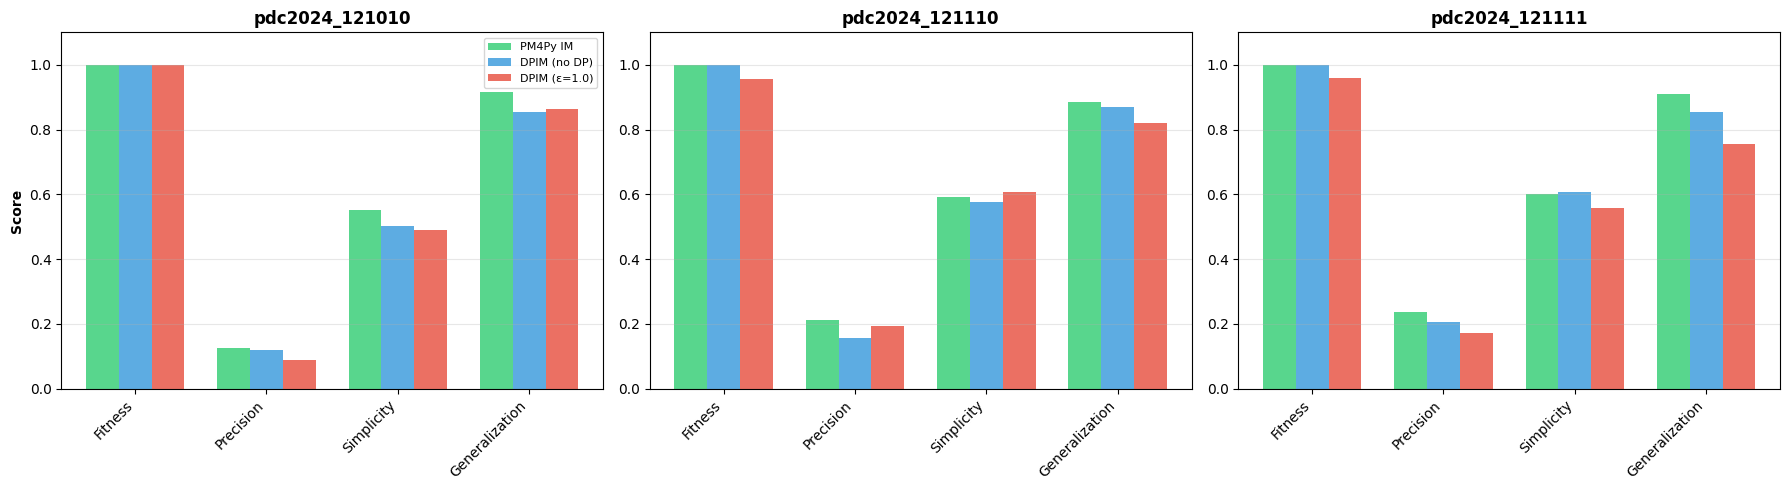


COMPARISON: BPI 2024 CHALLENGE DATASETS

pdc2024_121010:
Metric          PM4Py IM        DPIM (no DP)    DPIM (ε=1.0)    DP Impact   
---------------------------------------------------------------------------
Fitness         1.0000          1.0000          1.0000          +0.0%
Precision       0.1259          0.1202          0.0898          -25.3%
Simplicity      0.5529          0.5038          0.4891          -2.9%
Generalization  0.9158          0.8554          0.8632          +0.9%

pdc2024_121110:
Metric          PM4Py IM        DPIM (no DP)    DPIM (ε=1.0)    DP Impact   
---------------------------------------------------------------------------
Fitness         1.0000          1.0000          0.9551          -4.5%
Precision       0.2115          0.1578          0.1922          +21.8%
Simplicity      0.5929          0.5758          0.6063          +5.3%
Generalization  0.8854          0.8688          0.8210          -5.5%

pdc2024_121111:
Metric          PM4Py IM        DPIM (no

In [ ]:
# Simple visualization: Compare all datasets
metrics = ['Fitness', 'Precision', 'Simplicity', 'Generalization']
datasets = list(bpi_results.keys())

fig, axes = plt.subplots(1, len(datasets), figsize=(6*len(datasets), 5))
if len(datasets) == 1:
    axes = [axes]

for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    data = bpi_results[dataset]
    
    # Simple bar chart
    x = np.arange(len(metrics))
    width = 0.25
    
    ax.bar(x - width, data['PM4Py IM'], width, label='PM4Py IM', color='#2ecc71', alpha=0.8)
    ax.bar(x, data['DPIM (no DP)'], width, label='DPIM (no DP)', color='#3498db', alpha=0.8)
    ax.bar(x + width, data['DPIM (ε=1.0)'], width, label='DPIM (ε=1.0)', color='#e74c3c', alpha=0.8)
    
    ax.set_title(dataset, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3)
    if idx == 0:
        ax.set_ylabel('Score', fontweight='bold')
        ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*100)
print("COMPARISON: BPI 2024 CHALLENGE DATASETS")
print("="*100)
for dataset in datasets:
    print(f"\n{dataset}:")
    print(f"{'Metric':<15} {'PM4Py IM':<15} {'DPIM (no DP)':<15} {'DPIM (ε=1.0)':<15} {'DP Impact':<12}")
    print("-"*75)
    for i, metric in enumerate(metrics):
        pm4py_val = bpi_results[dataset]['PM4Py IM'][i]
        dpim_val = bpi_results[dataset]['DPIM (no DP)'][i]
        dpim_dp_val = bpi_results[dataset]['DPIM (ε=1.0)'][i]
        impact = ((dpim_dp_val - dpim_val) / dpim_val * 100) if dpim_val > 0 else 0
        print(f"{metric:<15} {pm4py_val:<15.4f} {dpim_val:<15.4f} {dpim_dp_val:<15.4f} {impact:+.1f}%")
print("="*100)
